In [1]:
# Imports
import os
import re
from collections import OrderedDict, Counter
from nltk.util import ngrams
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from data_functions import *

In [2]:
# Defines
pathToLyrics = './lyrics/'
tokenPattern = "\\b[a-zA-Z]+\\b"
regex = re.compile(tokenPattern)
stopWords = set(stopwords.words('english'))

In [3]:
# Initializations
corpus = []
artists = OrderedDict()
numSongs = 0
numWords = 0

titleUnigrams = Counter()
titleBigrams = Counter()
unigrams = Counter()
bigrams = Counter()
trigrams = Counter()

In [4]:
# loop through artist subfolders in lyrics folder
for subdir, dirs, files in os.walk(pathToLyrics):
    if subdir == pathToLyrics:
        continue

    artist = subdir[subdir.rindex('/') + 1:].title()
    artists[artist] = len(corpus)  # index in corpus array to retrieve artist data
    artistDoc = ""
    
    # loop through artist's songs
    for file in files:
        try:
            fh = open(subdir + '/' + file, "r")
            lyrics = fh.read()
            fh.close()
            numSongs += 1
        except:
            continue  # skip if error opening file

        # keep counters of words in song title
        idx = lyrics.index('\n')  # first line is song title
        words = tokenizeSentence(lyrics[:idx], regex)
        titleUnigrams.update(words)
        titleBigrams.update(ngrams(words, 2))

        for sentence in lyrics[idx+1:].splitlines():
            words = tokenizeSentence(sentence, regex)
            artistDoc += ' '.join(words) + ' '
            
            # update global counts of n=1 to n=3 gram frequencies
            numWords += len(words)
            unigrams.update(words)
            bigrams.update(ngrams(words, 2))
            trigrams.update(ngrams(words, 3))
    corpus.append(artistDoc)

In [5]:
# Create vectorizer objects for analysis

# pure word counts
cv = CountVectorizer(token_pattern=tokenPattern)
counts = cv.fit_transform(corpus).toarray()

# normalized word counts (since we collect more songs for some artists)
tv1 = TfidfVectorizer(token_pattern=tokenPattern, norm='l2', use_idf=False)
tf = tv1.fit_transform(corpus).toarray()

# normalized word counts with idf weighting
tv2 = TfidfVectorizer(token_pattern=tokenPattern, norm='l2', use_idf=True)
tfidf = tv2.fit_transform(corpus).toarray()

allWords = cv.get_feature_names()
wordIdxs = {allWords[i]: i for i in range(len(allWords))}  # for quick lookup at word level

## Lyric Collection Overview

In [6]:
allArtists = list(artists.keys())
print("Number of artists: {}".format(len(allArtists)))
print("Some of the artists are:")
print(*allArtists[:8], sep=', ')

Number of artists: 150
Some of the artists are:
Justin Timberlake, Ellie Goulding, Harry Styles, Mike Posner, Leona Lewis, Jay Sean, Lizzo, Justin Bieber


In [7]:
print("Number of songs: {}".format(numSongs))
print("Number of words: {}".format(numWords))
print("Average words per song: {:.1f}".format(numWords / numSongs))
print("Number of unique words: {}".format(len(unigrams)))

Number of songs: 2144
Number of words: 756487
Average words per song: 352.8
Number of unique words: 14378


## Song Title Analysis

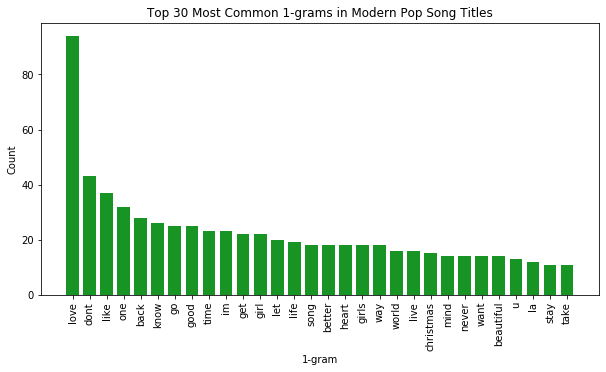

In [8]:
filtered = [x for x in titleUnigrams.most_common() if x[0] not in stopWords][:30]
plotBarGraph(filtered, 1, True, "")

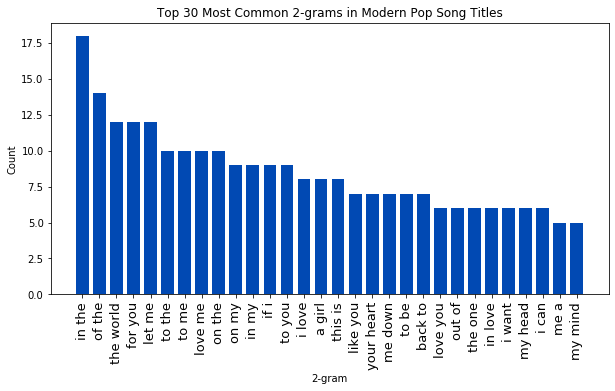

In [9]:
plotBarGraph(titleBigrams.most_common(30), 2, True, "")

## Lyric Analysis

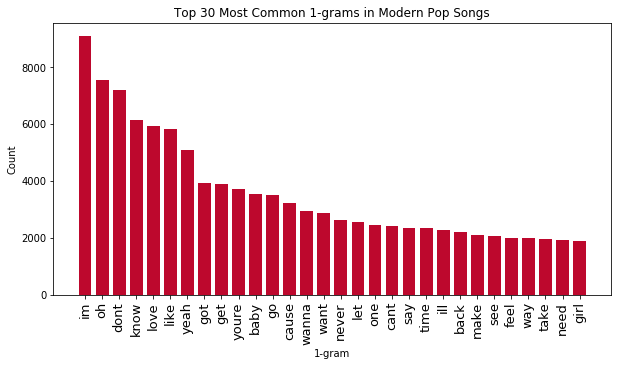

In [10]:
filtered = [x for x in unigrams.most_common() if x[0] not in stopWords][:30]
plotBarGraph(filtered, 1, False, "")

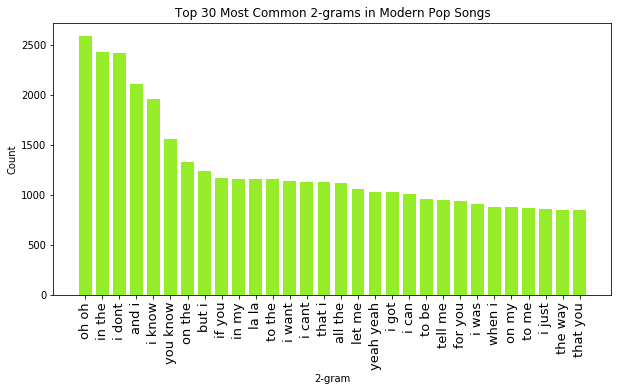

In [11]:
plotBarGraph(bigrams.most_common(30), 2, False, "")

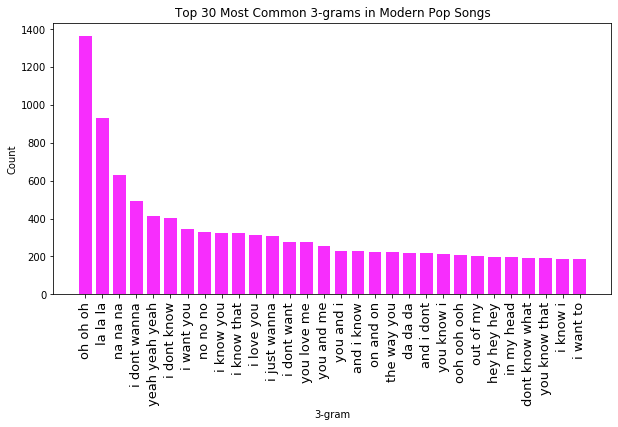

In [12]:
plotBarGraph(trigrams.most_common(30), 3, False, "")

## Artist Lyric Breakdown

#### Choose an artist

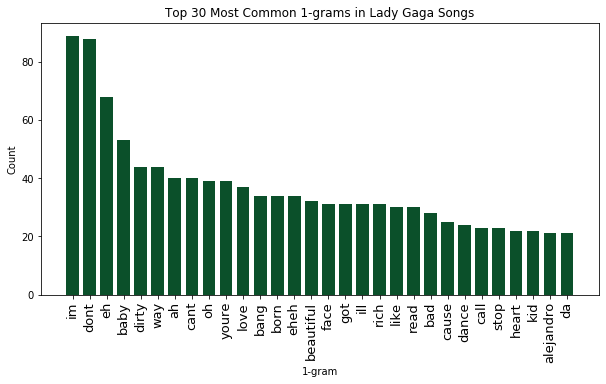

In [13]:
artist = 'Lady Gaga'
displayArtistWords(artist, artists, allWords, counts)

## Word Popularity

#### Choose a word to see which artists have used it

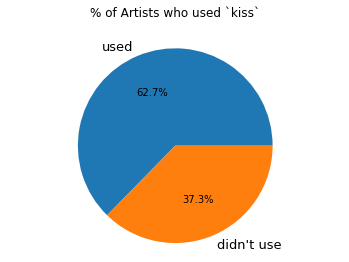


And these artists used kiss the most

+--------------------+--------------+
|       Artist       | Uses of kiss |
+--------------------+--------------+
|      Dua Lipa      |      79      |
|   Ashley Tisdale   |      28      |
| Christina Aguilera |      19      |
|  Kelsea Ballerini  |      18      |
|  Carly Rae Jepsen  |      15      |
+--------------------+--------------+


In [14]:
word = 'kiss'
getWordStats(word, wordIdxs, counts, allArtists)

## Artist Lyric Comparison

#### Compare two artists, or choose just artist1 (artist2 = None)

In [15]:
artist1 = 'One Direction'
artist2 = None
compareArtists(artist1, artist2, artists, tf, tfidf, allWords)


Artists with most similar vocabulary to One Direction

+----------------+--------------------+----------------------+-------------------------+
|     Artist     | Jaccard Similarity | TF Cosine Similarity | TFIDF Cosine Similarity |
+----------------+--------------------+----------------------+-------------------------+
|  Shawn Mendes  |       0.363        |        0.899         |          0.798          |
| Julia Michaels |       0.295        |         0.88         |          0.794          |
|    Dua Lipa    |       0.307        |        0.865         |          0.778          |
|   Bea Miller   |       0.309        |        0.872         |          0.776          |
|     Bazzi      |       0.274        |        0.866         |          0.776          |
+----------------+--------------------+----------------------+-------------------------+
